In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Created on Thu May 25 14:47:58 2023

@author: mariapopovic
"""

from numpy import array, exp, append, linspace, log, average, around, arange, sqrt, random, inf, multiply, linalg
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from math import erf, pi, erfc
from scipy.special import erfinv
from scipy.integrate import quad
from scipy.stats import norm
from statistics import mean, stdev
from sklearn.metrics import mean_absolute_error
from numpy.linalg import eig

In [6]:
class optimal_quantizers(object):
    
    def __init__(self,p):
        
        self.mu = p[0]
        self.sigma = p[1]
        
        n = [1,2,3,4,5,6,7,8,9,10] # This is the number of qubits needed to encode 2^n bins on a quantum comp
        self.number_bins_list = []
        
        index = 0
        for el in n:
            self.number_bins_list.append(2**int(el)) # Possible numbers of bins
            index = index + 1
        
        ##### EQUIMASS KNOTS #####
        self.probabilities_equimass = [[]]*len(self.number_bins_list)
        self.knots_equimass = [] # Equimass knots
        self.cdf_equimass_rightbound = []
        self.y_equimass = [] # Equimass quantizers
        
        ##### STATIONARY KNOTS #####
        self.probabilities_stationary = [[]]*len(self.number_bins_list)
        self.knots_stationary= [] 
        self.cdf_stationary_rightbound = []
        self.y_stationary = [] 

        ##### LINEAR KNOTS #####
        self.probabilities_linear = [[]]*len(self.number_bins_list)
        self.knots_linear = [] 
        self.cdf_linear_rightbound = [[]]*len(self.number_bins_list)
        self.y_linear = [] 

        
        
    ############################# EQUIMASS ###########################################
    
    # Define equimass knots and their probabilitites
    def create_equimass_knots(self):
        
        cell_bounds_equimass = [[]]*len(self.number_bins_list)
        
        def inverse_cdf(y):
            return sqrt(2)*erfinv(2*y - 1)
        
        # Probabilities for equi-mass quantizer, same for every knot

        for index_bins in range(0,len(self.number_bins_list)):
    
            el = self.number_bins_list[index_bins]
            self.probabilities_equimass[index_bins] = append(self.probabilities_equimass[index_bins], [1/el]*el)
    

        for n in self.number_bins_list:
    
            gammas_equimass = []
    
            for i in range(1, n + 1):
        
                num_i = exp(-((inverse_cdf((i-1)/n))**2)/2) - exp(-((inverse_cdf(i/n))**2)/2)
                gamma_i = (n/(sqrt(2*pi)))*(num_i)
                gammas_equimass.append(gamma_i*self.sigma + self.mu)
     
            self.knots_equimass.append(gammas_equimass)

    
        # Create bounds for cells

        for index_bins in range(0,len(self.number_bins_list)):
    
            n = self.number_bins_list[index_bins]
       
            for i in range(0, n+1):
                cell_bounds_equimass[index_bins] = append(cell_bounds_equimass[index_bins],inverse_cdf(i/n)*self.sigma + self.mu)


        # Define the cumulative distribution function from the right extreme of each cell

        for index_bins in range(0,len(self.number_bins_list)):
            self.cdf_equimass_rightbound.append(norm.cdf(cell_bounds_equimass[index_bins][1:]))
    
        # Round last element to = 1

        for index_bins in range(0,len(self.number_bins_list)):
    
            tmp = self.cdf_equimass_rightbound[index_bins][:-1]
            self.cdf_equimass_rightbound[index_bins] = append(tmp,round(self.cdf_equimass_rightbound[index_bins][-1]))

    # Extract one equimass quantizer according to their probability distribution
    def equimass_quantizer(self):
        
        self.y_equimass = []
        
        u = random.uniform(0,1)
        
        for index_bins in range(0,len(self.number_bins_list)):
        
            index2 = 0
    
            while self.cdf_equimass_rightbound[index_bins][index2] < u:
                index2 = index2 + 1

            self.y_equimass.append(self.knots_equimass[index_bins][index2])
            
    ############################# STATIONARY ###########################################
    
    # Define stationary knots and their probabilitites
    def create_stationary_knots(self):
        
        # Set of equations to solve for stationary knots
        
        def probabilities(a, b):
        
            return quad(lambda x: (1/(sqrt(2*pi)*self.sigma))*exp(-(((x - self.mu)/self.sigma)**2)/2), a, b)[0]
        

        def prob_equations_stat(g0,g1,g2):
            #p_i
            return 0.5*(erf((g2 + g1)/(2*sqrt(2))) - erf((g0 + g1)/(2*sqrt(2))))

        
        def knot_equations_stat(g0,g1,g2):
            #gamma_i
            den = (sqrt(2*pi)*prob_equations_stat(g0,g1,g2))
            den -= 1e-15
            
            return (exp(-((g0 + g1)**2)/8) - exp(-((g2 + g1)**2)/8))/den
        
        # Solve equations for knots and corresponding probabilities
        for index_bins in range(0,len(self.number_bins_list)):
        
            n = int(self.number_bins_list[index_bins]/2)
           
            def equations_stationary_knots(p):
    
                eq_list = [p[0] - knot_equations_stat(-p[0],p[0],p[1])]
    
                for index in range(1,n-1):
        
                    eq_list.append(p[index] - knot_equations_stat(p[index-1],p[index],p[index + 1]))
    
                eq_list.append(p[n - 1] - knot_equations_stat(p[n - 2],p[n - 1],inf))
        
                return eq_list     
            
            start_points = []
            j = 1
            while j <= n:
                start_points.append(3*j/n)
                j = j + 1
    
            # n = 1
        
            def eq1(p):
                
                return p - knot_equations_stat(0,p,inf)
            
            if n == 1:
                gammas_stationary = fsolve(eq1, 3)

            else:
                gammas_stationary = fsolve(equations_stationary_knots, start_points)
                
                
            
            tmp = append(- gammas_stationary[::-1],gammas_stationary)
            
            # If mean is not 0 and variance is not 1
            for index in range(0, len(tmp)):
                
                tmp[index] =  tmp[index]*self.sigma + self.mu

            self.knots_stationary.append(tmp)
         
        # Create cells
            
        cell_bounds_stationary = []
        
        for index_bins in range(0,len(self.number_bins_list)):
    
            
            cell_bounds_stationary.append([-inf])
            
            for index2 in range(1,len(self.knots_stationary[index_bins])):
    
                cell_bounds_stationary[index_bins].append((self.knots_stationary[index_bins][index2] + self.knots_stationary[index_bins][index2 - 1])/2)
        
            # Append extreme right bound
    
            cell_bounds_stationary[index_bins].append(inf)
        
    
            # Define the cumulative distribution function from the right extreme of each cell

            self.cdf_stationary_rightbound.append(norm.cdf(cell_bounds_stationary[index_bins][1:]))

            # Round last element to = 1
    
            tmp = self.cdf_stationary_rightbound[index_bins][:-1]
            self.cdf_stationary_rightbound[index_bins] = append(tmp,round(self.cdf_stationary_rightbound[index_bins][-1]))
       
    # Create probabilities
    
        for index_bins in range(0,len(self.number_bins_list)):
            
            for index in range(0,len(cell_bounds_stationary[index_bins]) - 1):
                new_prob = probabilities(cell_bounds_stationary[index_bins][index], cell_bounds_stationary[index_bins][index + 1])
                self.probabilities_stationary[index_bins] = append(self.probabilities_stationary[index_bins], new_prob )
        

    # Extract one stationary quantizer according to their probability distribution
    def stationary_quantizer(self):
        
        self.y_stationary = []
        
        u = random.uniform(0,1)
        
        for index_bins in range(0,len(self.number_bins_list)):
        
            index2 = 0
    
            while self.cdf_stationary_rightbound[index_bins][index2] < u:
                index2 = index2 + 1

            self.y_stationary.append(self.knots_stationary[index_bins][index2])
            
    ############################# LINEAR ###########################################

    # Define linear knots and their probabilitites
    def create_linear_knots(self):
        
        alpha_list = []
        cell_bounds_linear = [[]]*len(self.number_bins_list)
        
        def probabilities(a, b):
        
            return quad(lambda x: (1/(sqrt(2*pi)*self.sigma))*exp(-(((x - self.mu)/self.sigma)**2)/2), a, b)[0]
           
        
        for index_bin in range(0,len(self.number_bins_list)):
    
            n = self.number_bins_list[index_bin]/2

        
            def equations_optimal_linear(alpha):
        
        
                def first_integral(n,j,alpha):
    
                    term1 = 2*n*(exp(-(((j-1)**2)*(alpha**2))/(2*(n**2))) - exp(-((j**2)*(alpha**2))/(2*(n**2))))
    
                    term2 = (2*j - 1)*alpha*sqrt(pi/2)*(erf(((j-1)*alpha)/(sqrt(2)*n)) - erf((j*alpha)/(sqrt(2)*n)))

                    return -((2*j - 1)/(4*n*sqrt(2*pi)))*(term1 + term2)

                def second_integral(n,alpha):
    
                    term1 = -2*sqrt(2/pi)*exp(-(((n-1)**2)*(alpha**2))/(2*(n**2)))
    
                    term2 = (2*n - 1)*(alpha/n)*erfc(((n-1)*alpha)/(sqrt(2)*n))
    
                    return (1/8)*(2*n - 1)*(term1 + term2)

                def first_integral_sum(n,alpha):
    
                    sum_index = 0
                    j = 1
    
                    while j < n:
                        sum_index = sum_index + first_integral(n,j,alpha)
                        j = j + 1
    
                    return sum_index

                return first_integral_sum(n,alpha) + second_integral(n,alpha)

            a = fsolve(equations_optimal_linear,1)
            alpha_list.append(a)
    
            start = -a + (a/(2*n)) # for even quantizers
            h = a/n
            j = 1
            gammas_linear = []
            while j <= n:
                el = h*(j - (1/2))
                gammas_linear = append(gammas_linear,el)
                j = j + 1
            
            tmp = append(-gammas_linear[::-1],gammas_linear)
            
            # If mean is not 0 and variance is not 1
            for index in range(0, len(tmp)):
                
                tmp[index] =  tmp[index]*self.sigma + self.mu

            self.knots_linear.append(tmp)
            
            # Cell bounds
            
            cell_bounds_linear[index_bin] = append(cell_bounds_linear[index_bin], -inf)
            
            
            j = 0
            while j < 2*n - 1:
                bound = start + (h/2) + j*h
                cell_bounds_linear[index_bin] = append(cell_bounds_linear[index_bin], self.sigma*bound + self.mu)
                self.cdf_linear_rightbound[index_bin] = append(self.cdf_linear_rightbound[index_bin],norm.cdf(cell_bounds_linear[index_bin][-1]))
                j = j + 1
            
            
            # Last bin
            cell_bounds_linear[index_bin] = append(cell_bounds_linear[index_bin], inf)
            self.cdf_linear_rightbound[index_bin] = append(self.cdf_linear_rightbound[index_bin],norm.cdf(cell_bounds_linear[index_bin][-1]))

    # Create probabilities
        for index_bins in range(0,len(self.number_bins_list)):
            
            for index in range(0,len(cell_bounds_linear[index_bins]) - 1):
                
                new_prob = probabilities(cell_bounds_linear[index_bins][index], cell_bounds_linear[index_bins][index + 1])
                self.probabilities_linear[index_bins] = append(self.probabilities_linear[index_bins], new_prob )
            
    
    # Extract one linear quantizer according to their probability distribution
    def linear_quantizer(self):
        
        self.y_linear = []
        
        u = random.uniform(0,1)
        
        for index_bins in range(0,len(self.number_bins_list)):
        
            index2 = 0
    
            while self.cdf_linear_rightbound[index_bins][index2] < u:
                index2 = index2 + 1

            self.y_linear.append(self.knots_linear[index_bins][index2])
        

In [7]:
alpha = 0.5
covariance = [[1,alpha],[alpha,1]]

e_val = eig(covariance)[0]
e_vect = eig(covariance)[1] #renormalized
e1 = sorted(e_vect[1])
e2 = sorted(e_vect[0])

p1 = [0, 2*e_val[0]]
p2 = [0, 2*e_val[1]]

# Create stationary, linear and equimass knots

quantizers_e1 = optimal_quantizers(p1)
quantizers_e2 = optimal_quantizers(p2)

quantizers_e1.create_stationary_knots()
quantizers_e2.create_stationary_knots()

quantizers_e1.create_linear_knots()
quantizers_e2.create_linear_knots()

quantizers_e1.create_equimass_knots()
quantizers_e2.create_equimass_knots()


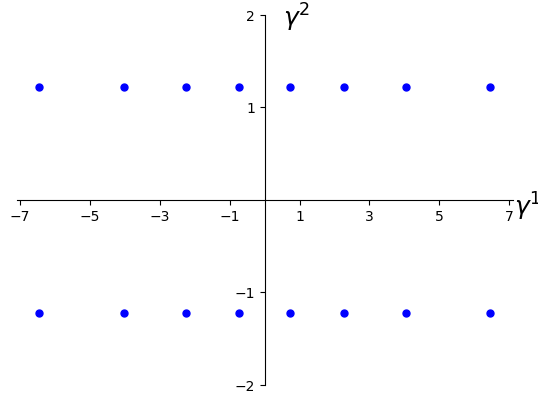

In [8]:
### Codebook example

knots1_stationary = quantizers_e1.knots_stationary[2] # n = 8
knots2_stationary = quantizers_e2.knots_stationary[0] # m = 2

codebook12_stationary = []
for index in range(0, len(knots1_stationary)):
    codebook12_stationary.append([knots1_stationary[index],knots2_stationary[0]])
    codebook12_stationary.append([knots1_stationary[index],knots2_stationary[1]])
    
    
codebook_stationary = []
for k1 in knots1_stationary:
    for k2 in knots2_stationary:
        el = multiply(e1,k1) + multiply(e2,k2)
        codebook_stationary.append(el)

f1 = plt.figure(1)
ax = plt.axes()
for index in range(0,len(codebook12_stationary)):
    ax.plot(codebook12_stationary[index][0], codebook12_stationary[index][1], marker = ".",markersize=10, linewidth = 0, color = 'blue')

ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xmin, xmax, ymin, ymax = -7, 7, -2, 2
x_ticks = arange(xmin, xmax+1, 2)
y_ticks = arange(ymin, ymax+1, 1)
ax.set_xticks(x_ticks[x_ticks != 0])
ax.set_yticks(y_ticks[y_ticks != 0])

ax.set_xlabel(r'$\gamma^{1}$', size=18, labelpad=-24, x=1.03)
ax.set_ylabel(r'$\gamma^{2}$', size=18, labelpad=-45, y=0.95, rotation=0)

#plt.tight_layout()


plt.show()

In [9]:
def bivariate_distribution_quantizers(alpha, e1, e2, q_e1, q_e2, z1, z2, n, m):


    knots1_stationary = q_e1.knots_stationary[n] # n = 8
    knots2_stationary = q_e2.knots_stationary[m] # m = 2

    knots1_linear = q_e1.knots_linear[n] # n = 8
    knots2_linear = q_e2.knots_linear[m] # m = 2

    knots1_equimass = q_e1.knots_equimass[n] # n = 8
    knots2_equimass = q_e2.knots_equimass[m] # m = 2

    cdf1_stationary = q_e1.cdf_stationary_rightbound[n]
    cdf2_stationary = q_e2.cdf_stationary_rightbound[m]

    cdf1_linear = q_e1.cdf_linear_rightbound[n]
    cdf2_linear = q_e2.cdf_linear_rightbound[m]

    cdf1_equimass = q_e1.cdf_equimass_rightbound[n]
    cdf2_equimass = q_e2.cdf_equimass_rightbound[m]
    
    ###
    

    X = array([[1,0],[alpha, sqrt(1 - (alpha**2))]]).dot(array([z1,z2]))
    X = multiply(1/linalg.norm(X), X)
    scalar_e1X = X.dot(e1)
    scalar_e2X = X.dot(e2)

    index1 = 0
    while cdf1_stationary[index1] < scalar_e1X:
        index1 = index1 + 1
    index2 = 0
    while cdf2_stationary[index2] < scalar_e2X:
        index2 = index2 + 1

    y1_stationary = knots1_stationary[index1]
    y2_stationary = knots2_stationary[index2]

    index1 = 0
    while cdf1_linear[index1] < scalar_e1X:
        index1 = index1 + 1
    index2 = 0
    while cdf2_linear[index2] < scalar_e2X:
        index2 = index2 + 1

    y1_linear = knots1_linear[index1]
    y2_linear = knots2_linear[index2]
    
    index1 = 0
    while cdf1_equimass[index1] < scalar_e1X:
        index1 = index1 + 1
    index2 = 0
    while cdf2_equimass[index2] < scalar_e2X:
        index2 = index2 + 1

    y1_equimass = knots1_equimass[index1]
    y2_equimass = knots2_equimass[index2]
    
    
    y12_stationary = multiply(e1,y1_stationary) + multiply(e2,y2_stationary)
    y12_linear = multiply(e1,y1_linear) + multiply(e2,y2_linear)
    y12_equimass = multiply(e1,y1_equimass) + multiply(e2,y2_equimass)
    
    return y12_stationary, y12_linear, y12_equimass


In [11]:
z1 = random.normal(0,1)
z2 = random.normal(0,1)

y12_stat, y12_lin, y12_eq = bivariate_distribution_quantizers(alpha, e1, e2, quantizers_e1, quantizers_e2, z1, z2, 2, 0)

print('Random stationary 2D variable: ' + str(y12_stat))
print('Random linear 2D variable: ' + str(y12_lin))
print('Random equimass 2D variable: ' + str(y12_eq))

Random stationary 2D variable: [2.46923258 0.73822618]
Random linear 2D variable: [2.42889203 1.30051286]
Random equimass 2D variable: [1.60649897 0.4781198 ]


In [24]:
## Multi-asset Black-Scholes

r = 0.05
T = 0.25 # Expiry date
sigma1 = 0.5 # Volatility
sigma2 = 0.2 # Volatility
s0_1 = 1
s0_2 = 0.8

def black_scholes_2D (rate, expiry, s1, s2, sig1, sig2, w, cov):

    s1_T = s1*exp( (rate - 0.5*( abs(sig1)**2 ))*expiry + sqrt(expiry)*(array(cov).dot(w))[0] )
    s2_T = s2*exp( (rate - 0.5*( abs(sig2)**2 ))*expiry + sqrt(expiry)*(array(cov).dot(w))[1] )
    
    return s1_T, s2_T

In [27]:
iterations = 100000
m_index = 0


blackscholes_brownian1 = []
blackscholes_brownian2 = []
blackscholes_linear1 = [[]]*9
blackscholes_linear2 = [[]]*9
blackscholes_stationary1 = [[]]*9
blackscholes_stationary2 = [[]]*9
blackscholes_equimass1 = [[]]*9
blackscholes_equimass2 = [[]]*9


standard_error_linear1 = []
standard_error_linear2 = []
standard_error_stationary1 = []
standard_error_stationary2 = []
standard_error_equimass1 = []
standard_error_equimass2 = []

for _ in range(iterations):
    
    z1 = random.normal(0,1)
    z2 = random.normal(0,1)
    

    X = array([[1,0],[alpha, sqrt(1 - (alpha**2))]]).dot(array([z1,z2]))
    #X = multiply(1/linalg.norm(X), X)
    
    bm1, bm2 = black_scholes_2D(r, T, s0_1, s0_2, sigma1, sigma2, X, covariance)
    blackscholes_brownian1.append(bm1)
    blackscholes_brownian2.append(bm2)
    
    #for m_index in range(0, n_index):
    for n_index in range(0, 9):
        
        y12_stat, y12_lin, y12_eq  = bivariate_distribution_quantizers(alpha, e1, e2, quantizers_e1, quantizers_e2, z1, z2, n_index + 1, m_index)

        bm1_stat, bm2_stat = black_scholes_2D(r, T, s0_1, s0_2, sigma1, sigma2, y12_stat, covariance)
        bm1_lin, bm2_lin = black_scholes_2D(r, T, s0_1, s0_2, sigma1, sigma2, y12_lin, covariance)
        bm1_eq, bm2_eq = black_scholes_2D(r, T, s0_1, s0_2, sigma1, sigma2, y12_eq, covariance)
    
        blackscholes_stationary1[n_index] = append(blackscholes_stationary1[n_index],bm1_stat)
        blackscholes_stationary2[n_index] = append(blackscholes_stationary2[n_index],bm2_stat)
        
        blackscholes_linear1[n_index] = append(blackscholes_linear1[n_index],bm1_lin)
        blackscholes_linear2[n_index] = append(blackscholes_linear2[n_index],bm2_lin)
    
        blackscholes_equimass1[n_index] = append(blackscholes_equimass1[n_index],bm1_eq)
        blackscholes_equimass2[n_index] = append(blackscholes_equimass2[n_index],bm2_eq)

        
mean_stationary_blackscholes1 = []
mean_stationary_blackscholes2 = []

mean_linear_blackscholes1 = []
mean_linear_blackscholes2 = []

mean_equimass_blackscholes1 = []
mean_equimass_blackscholes2 = []

#for m_index in range(0, n_index):
for n_index in range(0, 9):
    
    mean_stationary_blackscholes1.append(average(blackscholes_stationary1[n_index]))
    mean_stationary_blackscholes2.append(average(blackscholes_stationary2[n_index]))
    
    mean_linear_blackscholes1.append(average(blackscholes_linear1[n_index]))
    mean_linear_blackscholes2.append(average(blackscholes_linear2[n_index]))
    
    mean_equimass_blackscholes1.append(average(blackscholes_equimass1[n_index]))
    mean_equimass_blackscholes2.append(average(blackscholes_equimass2[n_index]))
    
    
    standard_error_stationary1.append(stdev(blackscholes_stationary1[n_index])/sqrt(iterations))
    standard_error_stationary2.append(stdev(blackscholes_stationary2[n_index])/sqrt(iterations))
    
    standard_error_linear1.append(stdev(blackscholes_linear1[n_index])/sqrt(iterations))
    standard_error_linear2.append(stdev(blackscholes_linear2[n_index])/sqrt(iterations))
    
    standard_error_equimass1.append(stdev(blackscholes_equimass1[n_index])/sqrt(iterations))
    standard_error_equimass2.append(stdev(blackscholes_equimass2[n_index])/sqrt(iterations))
    
mean_brownian_blackscholes1 = [average(blackscholes_brownian1)]*9
mean_brownian_blackscholes2 = [average(blackscholes_brownian2)]*9

standard_error_brownian1 = [stdev(blackscholes_brownian1)/sqrt(iterations)]*9
standard_error_brownian2 = [stdev(blackscholes_brownian2)/sqrt(iterations)]*9

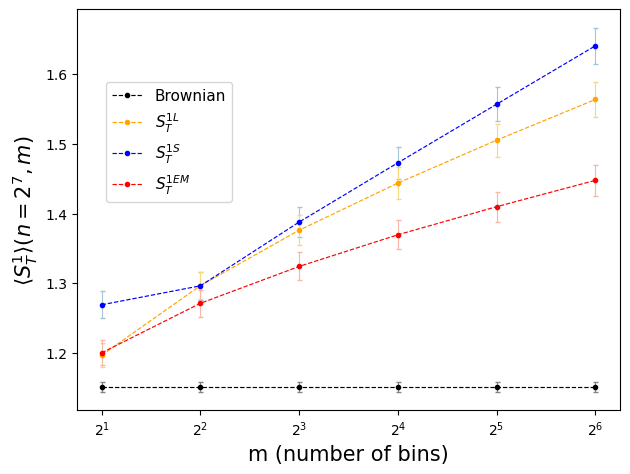

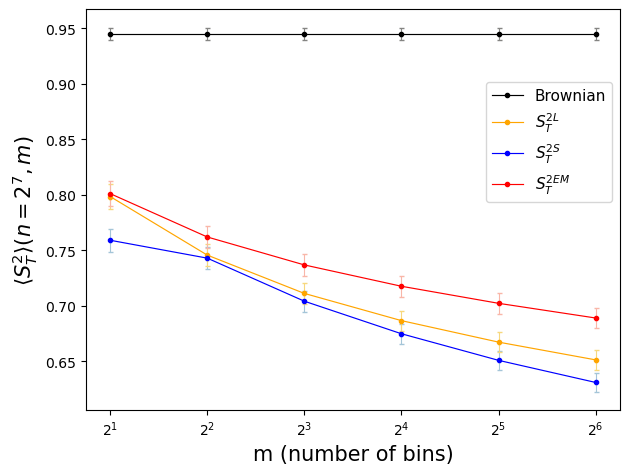

In [140]:
f1 = plt.figure(1)
ax=plt.axes()

# Asset 1
ax.errorbar([2**x for x in range(1, n_index + 1)], mean_stationary_blackscholes1,
            xerr=0,
            yerr= standard_error_stationary1,
            fmt='none',
            elinewidth = 0.8,
            color = 'blue',
            ecolor = '#A4C5D8',
            capsize=1.8)


ax.errorbar([2**x for x in range(1, n_index + 1)], mean_linear_blackscholes1,
               xerr=0,
               yerr= standard_error_linear1,
               fmt='none',
               elinewidth = 0.8,
               color = 'orange',
               ecolor = '#F7D87D',
               capsize = 1.8)

ax.errorbar([2**x for x in range(1, n_index + 1)], mean_equimass_blackscholes1,
            xerr=0,
            yerr= standard_error_equimass1,
            fmt='none',
            elinewidth = 0.8,
            color = 'red',
            ecolor = '#F9B6A8',
            capsize=1.8)

ax.errorbar([2**x for x in range(1, n_index + 1)], mean_brownian_blackscholes1,
            xerr=0,
            yerr= standard_error_brownian1,
            fmt='none',
            elinewidth = 0.8,
            color = 'black',
            ecolor = '#848482',
            capsize=1.8)


ax.plot([2**x for x in range(1,n_index + 1)],mean_brownian_blackscholes1,label='Brownian', marker = ".", markersize=6, linewidth = 0.85, color = 'black', linestyle = 'dashed')
ax.plot([2**x for x in range(1,n_index + 1)],mean_linear_blackscholes1,label=r'$S^{1L}_T$', marker = ".", markersize=6, linewidth = 0.85, color = 'orange', linestyle = 'dashed')
ax.plot([2**x for x in range(1,n_index + 1)],mean_stationary_blackscholes1,label=r'$S^{1S}_T$',marker = ".", markersize=6, linewidth = 0.85, color = 'blue',linestyle='dashed')
ax.plot([2**x for x in range(1,n_index + 1)],mean_equimass_blackscholes1,label=r'$S^{1EM}_T$',marker = ".", markersize=6, linewidth = 0.85, color = 'red',linestyle='dashed')

ax.set_xlabel('m (number of bins)',fontsize=15)
ax.set_ylabel(r'$\langle S^{1}_{T} \rangle (n = 2^7, m)$',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2) 
plt.legend(loc='lower right', bbox_to_anchor=(0.3, 0.5),fontsize=11)


plt.show()

# Asset 2

f2 = plt.figure(2)
ax2=plt.axes()

ax2.errorbar([2**x for x in range(1, n_index + 1)], mean_stationary_blackscholes2,
            xerr=0,
            yerr= standard_error_stationary2,
            fmt='none',
            elinewidth = 0.8,
            color = 'blue',
            ecolor = '#A4C5D8',
            capsize=1.8)


ax2.errorbar([2**x for x in range(1, n_index + 1)], mean_linear_blackscholes2,
               xerr=0,
               yerr= standard_error_linear2,
               fmt='none',
               elinewidth = 0.8,
               color = 'orange',
               ecolor = '#F7D87D',
               capsize = 1.8)

ax2.errorbar([2**x for x in range(1, n_index + 1)], mean_equimass_blackscholes2,
            xerr=0,
            yerr= standard_error_equimass2,
            fmt='none',
            elinewidth = 0.8,
            color = 'red',
            ecolor = '#F9B6A8',
            capsize=1.8)

ax2.errorbar([2**x for x in range(1, n_index + 1)], mean_brownian_blackscholes2,
            xerr=0,
            yerr= standard_error_brownian2,
            fmt='none',
            elinewidth = 0.8,
            color = 'black',
            ecolor = '#848482',
            capsize=1.8)


ax2.plot([2**x for x in range(1,n_index + 1)],mean_brownian_blackscholes2,label='Brownian', marker = ".", markersize=6, linewidth = 0.85, color = 'black')
ax2.plot([2**x for x in range(1,n_index + 1)],mean_linear_blackscholes2,label=r'$S^{2L}_T$', marker = ".", markersize=6, linewidth = 0.85, color = 'orange')
ax2.plot([2**x for x in range(1,n_index + 1)],mean_stationary_blackscholes2,label=r'$S^{2S}_T$',marker = ".", markersize=6, linewidth = 0.85, color = 'blue')
ax2.plot([2**x for x in range(1,n_index + 1)],mean_equimass_blackscholes2,label=r'$S^{2EM}_T$',marker = ".", markersize=6, linewidth = 0.85, color = 'red')

ax2.set_xlabel('m (number of bins)',fontsize=15)
ax2.set_ylabel(r'$\langle S^{2}_{T} \rangle (n = 2^7, m)$',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2) 
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.5),fontsize=11)


plt.show()

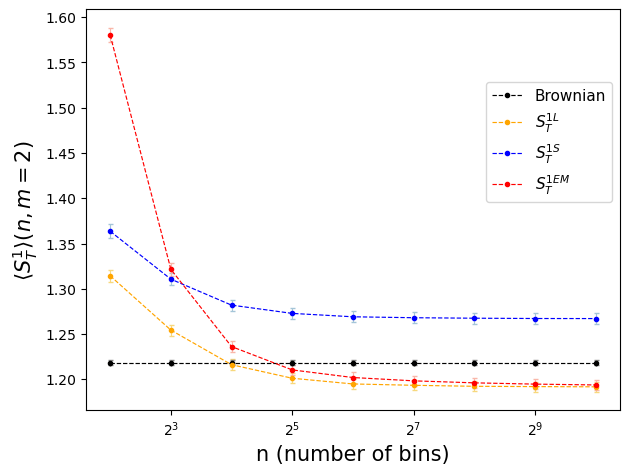

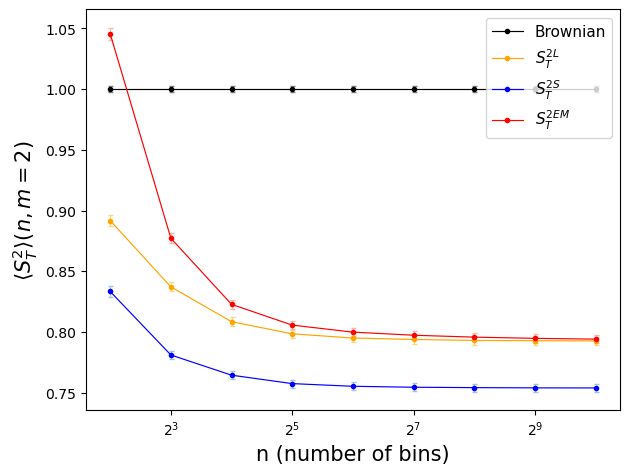

In [28]:
f1 = plt.figure(1)
ax=plt.axes()

# Asset 1
ax.errorbar([2**x for x in range(2,11)], mean_stationary_blackscholes1,
            xerr=0,
            yerr= standard_error_stationary1,
            fmt='none',
            elinewidth = 0.8,
            color = 'blue',
            ecolor = '#A4C5D8',
            capsize=1.8)


ax.errorbar([2**x for x in range(2,11)], mean_linear_blackscholes1,
               xerr=0,
               yerr= standard_error_linear1,
               fmt='none',
               elinewidth = 0.8,
               color = 'orange',
               ecolor = '#F7D87D',
               capsize = 1.8)

ax.errorbar([2**x for x in range(2,11)], mean_equimass_blackscholes1,
            xerr=0,
            yerr= standard_error_equimass1,
            fmt='none',
            elinewidth = 0.8,
            color = 'red',
            ecolor = '#F9B6A8',
            capsize=1.8)

ax.errorbar([2**x for x in range(2,11)], mean_brownian_blackscholes1,
            xerr=0,
            yerr= standard_error_brownian1,
            fmt='none',
            elinewidth = 0.8,
            color = 'black',
            ecolor = '#848482',
            capsize=1.8)


ax.plot([2**x for x in range(2,11)],mean_brownian_blackscholes1,label='Brownian', marker = ".", markersize=6, linewidth = 0.85, color = 'black', linestyle = 'dashed')
ax.plot([2**x for x in range(2,11)],mean_linear_blackscholes1,label=r'$S^{1L}_T$', marker = ".", markersize=6, linewidth = 0.85, color = 'orange', linestyle = 'dashed')
ax.plot([2**x for x in range(2,11)],mean_stationary_blackscholes1,label=r'$S^{1S}_T$',marker = ".", markersize=6, linewidth = 0.85, color = 'blue',linestyle='dashed')
ax.plot([2**x for x in range(2,11)],mean_equimass_blackscholes1,label=r'$S^{1EM}_T$',marker = ".", markersize=6, linewidth = 0.85, color = 'red',linestyle='dashed')

ax.set_xlabel('n (number of bins)',fontsize=15)
ax.set_ylabel(r'$\langle S^{1}_{T} \rangle (n, m = 2)$',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2) 
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.5),fontsize=11)


plt.show()

# Asset 2

f2 = plt.figure(2)
ax2=plt.axes()

ax2.errorbar([2**x for x in range(2,11)], mean_stationary_blackscholes2,
            xerr=0,
            yerr= standard_error_stationary2,
            fmt='none',
            elinewidth = 0.8,
            color = 'blue',
            ecolor = '#A4C5D8',
            capsize=1.8)


ax2.errorbar([2**x for x in range(2,11)], mean_linear_blackscholes2,
               xerr=0,
               yerr= standard_error_linear2,
               fmt='none',
               elinewidth = 0.8,
               color = 'orange',
               ecolor = '#F7D87D',
               capsize = 1.8)

ax2.errorbar([2**x for x in range(2,11)], mean_equimass_blackscholes2,
            xerr=0,
            yerr= standard_error_equimass2,
            fmt='none',
            elinewidth = 0.8,
            color = 'red',
            ecolor = '#F9B6A8',
            capsize=1.8)

ax2.errorbar([2**x for x in range(2,11)], mean_brownian_blackscholes2,
            xerr=0,
            yerr= standard_error_brownian2,
            fmt='none',
            elinewidth = 0.8,
            color = 'black',
            ecolor = '#848482',
            capsize=1.8)


ax2.plot([2**x for x in range(2,11)],mean_brownian_blackscholes2,label='Brownian', marker = ".", markersize=6, linewidth = 0.85, color = 'black')
ax2.plot([2**x for x in range(2,11)],mean_linear_blackscholes2,label=r'$S^{2L}_T$', marker = ".", markersize=6, linewidth = 0.85, color = 'orange')
ax2.plot([2**x for x in range(2,11)],mean_stationary_blackscholes2,label=r'$S^{2S}_T$',marker = ".", markersize=6, linewidth = 0.85, color = 'blue')
ax2.plot([2**x for x in range(2,11)],mean_equimass_blackscholes2,label=r'$S^{2EM}_T$',marker = ".", markersize=6, linewidth = 0.85, color = 'red')

ax2.set_xlabel('n (number of bins)',fontsize=15)
ax2.set_ylabel(r'$\langle S^{2}_{T} \rangle (n, m = 2)$',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2) 
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.66),fontsize=11)


plt.show()